In [28]:
import pyspark
from pyspark.sql.functions import col, sum
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [29]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('Project').getOrCreate()
spark

In [30]:
df_pyspark = spark.read.option('header','true').csv('insurance.csv')

In [31]:
#Conversion of required string categories into Float Categories
int_cols = ["age", "bmi", "children","charges"]
for col_name in int_cols:
    df_pyspark = df_pyspark.withColumn(col_name, col(col_name).cast("float"))
df_pyspark.show()

+----+------+------+--------+------+---------+---------+
| age|   sex|   bmi|children|smoker|   region|  charges|
+----+------+------+--------+------+---------+---------+
|19.0|female|  27.9|     0.0|   yes|southwest|16884.924|
|18.0|  male| 33.77|     1.0|    no|southeast|1725.5522|
|28.0|  male|  33.0|     3.0|    no|southeast| 4449.462|
|33.0|  male|22.705|     0.0|    no|northwest| 21984.47|
|32.0|  male| 28.88|     0.0|    no|northwest|3866.8552|
|31.0|female| 25.74|     0.0|    no|southeast|3756.6216|
|46.0|female| 33.44|     1.0|    no|southeast|  8240.59|
|37.0|female| 27.74|     3.0|    no|northwest|7281.5054|
|37.0|  male| 29.83|     2.0|    no|northeast|6406.4106|
|60.0|female| 25.84|     0.0|    no|northwest|28923.137|
|25.0|  male| 26.22|     0.0|    no|northeast|2721.3208|
|62.0|female| 26.29|     0.0|   yes|southeast|27808.725|
|23.0|  male|  34.4|     0.0|    no|southwest| 1826.843|
|56.0|female| 39.82|     0.0|    no|southeast|11090.718|
|27.0|  male| 42.13|     0.0|  

In [32]:
df_pyspark.printSchema()

root
 |-- age: float (nullable = true)
 |-- sex: string (nullable = true)
 |-- bmi: float (nullable = true)
 |-- children: float (nullable = true)
 |-- smoker: string (nullable = true)
 |-- region: string (nullable = true)
 |-- charges: float (nullable = true)



In [33]:
df_pyspark.count(),len(df_pyspark.columns)

(1338, 7)

In [34]:
null_counts = df_pyspark.select([sum(col(column).isNull().cast("int")).alias(column) for column in df_pyspark.columns])
null_counts.show()

+---+---+---+--------+------+------+-------+
|age|sex|bmi|children|smoker|region|charges|
+---+---+---+--------+------+------+-------+
|  0|  0|  0|       0|     0|     0|      0|
+---+---+---+--------+------+------+-------+



In [35]:
#Store Feature Matrix In X and Response(Target) In Vector y
X = df_pyspark.drop("charges")
# Extract 'charges' column as target variable
y = df_pyspark.select(col("charges"))

Building Vector Assembler in PySpark to Clear and Convert Data into required Data set for Applying ML Algorithm's

In [36]:
from pyspark.ml.feature import StringIndexer, VectorAssembler

indexer = StringIndexer(inputCols=["sex", "smoker", "region"], outputCols=["sex_indexed", "smoker_indexed", "region_indexed"])

# Fit and transform the DataFrame
df_transformed = indexer.fit(df_pyspark).transform(df_pyspark)

# Define the input columns for the VectorAssembler
input_cols = ['age', 'sex_indexed', 'bmi', 'children', 'smoker_indexed', 'region_indexed']

# Create the VectorAssembler and transform the DataFrame
assembler = VectorAssembler(inputCols=input_cols, outputCol="features")
df_transformed = assembler.transform(df_transformed)

# Select the transformed column
df_transformed.select('features').show()
df_transformed.show()

+--------------------+
|            features|
+--------------------+
|[19.0,1.0,27.8999...|
|[18.0,0.0,33.7700...|
|[28.0,0.0,33.0,3....|
|[33.0,0.0,22.7049...|
|[32.0,0.0,28.8799...|
|[31.0,1.0,25.7399...|
|[46.0,1.0,33.4399...|
|[37.0,1.0,27.7399...|
|[37.0,0.0,29.8299...|
|[60.0,1.0,25.8400...|
|[25.0,0.0,26.2199...|
|[62.0,1.0,26.2900...|
|[23.0,0.0,34.4000...|
|[56.0,1.0,39.8199...|
|[27.0,0.0,42.1300...|
|[19.0,0.0,24.6000...|
|[52.0,1.0,30.7800...|
|[23.0,0.0,23.8449...|
|[56.0,0.0,40.2999...|
|[30.0,0.0,35.2999...|
+--------------------+
only showing top 20 rows

+----+------+------+--------+------+---------+---------+-----------+--------------+--------------+--------------------+
| age|   sex|   bmi|children|smoker|   region|  charges|sex_indexed|smoker_indexed|region_indexed|            features|
+----+------+------+--------+------+---------+---------+-----------+--------------+--------------+--------------------+
|19.0|female|  27.9|     0.0|   yes|southwest|16884.924|      

In [37]:
df_finalize = df_transformed.select("features","charges")
df_finalize.show()

+--------------------+---------+
|            features|  charges|
+--------------------+---------+
|[19.0,1.0,27.8999...|16884.924|
|[18.0,0.0,33.7700...|1725.5522|
|[28.0,0.0,33.0,3....| 4449.462|
|[33.0,0.0,22.7049...| 21984.47|
|[32.0,0.0,28.8799...|3866.8552|
|[31.0,1.0,25.7399...|3756.6216|
|[46.0,1.0,33.4399...|  8240.59|
|[37.0,1.0,27.7399...|7281.5054|
|[37.0,0.0,29.8299...|6406.4106|
|[60.0,1.0,25.8400...|28923.137|
|[25.0,0.0,26.2199...|2721.3208|
|[62.0,1.0,26.2900...|27808.725|
|[23.0,0.0,34.4000...| 1826.843|
|[56.0,1.0,39.8199...|11090.718|
|[27.0,0.0,42.1300...|39611.758|
|[19.0,0.0,24.6000...| 1837.237|
|[52.0,1.0,30.7800...|10797.336|
|[23.0,0.0,23.8449...|2395.1716|
|[56.0,0.0,40.2999...|10602.385|
|[30.0,0.0,35.2999...| 36837.47|
+--------------------+---------+
only showing top 20 rows



In [38]:
df_finalize.describe().show()

+-------+------------------+
|summary|           charges|
+-------+------------------+
|  count|              1338|
|   mean|13270.422259640089|
| stddev|12110.011235594102|
|    min|         1121.8739|
|    max|          63770.43|
+-------+------------------+



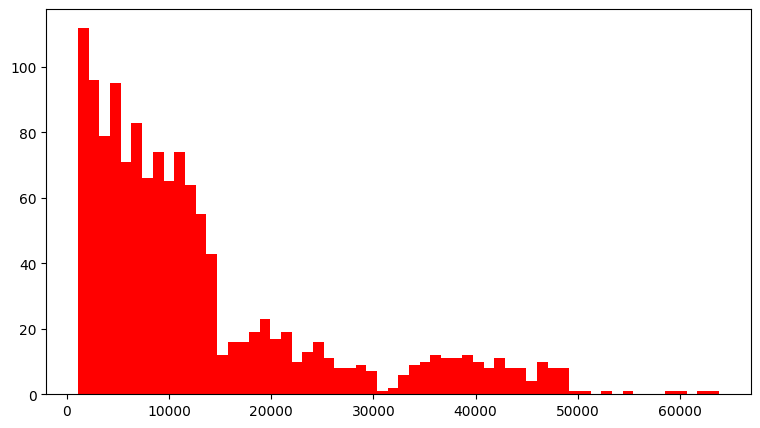

In [39]:
import matplotlib.pyplot as plt
import pyspark.sql.functions as F

# Compute the histogram of the 'charges' column
bins, counts = df_finalize.select('charges').rdd.flatMap(lambda x: x).histogram(60)

# Plot the histogram
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.hist(bins[:-1], bins=bins, weights=counts, color='r')
plt.show()


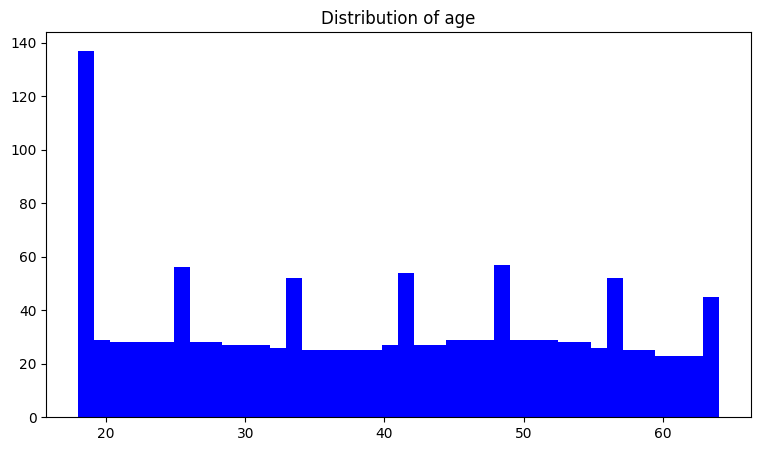

In [40]:
bins, counts = df_transformed.select('age').rdd.flatMap(lambda x: x).histogram(40)
# Plot the histogram
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.hist(bins[:-1], bins=bins, weights=counts, color='b')
plt.title('Distribution of age')
plt.show()

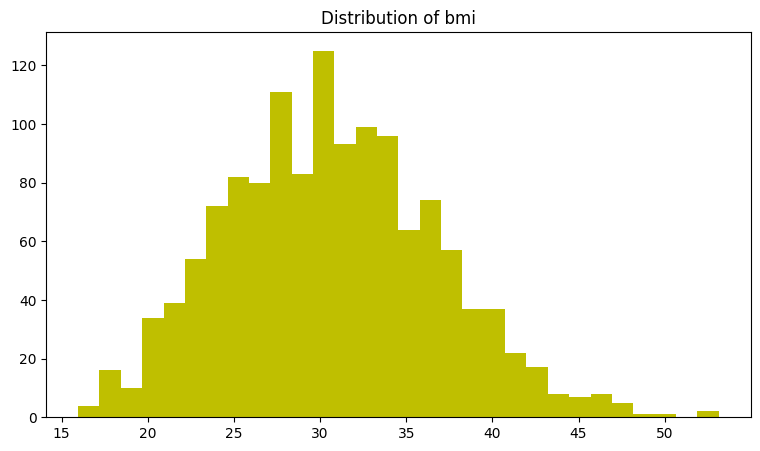

In [41]:
bins, counts = df_transformed.select('bmi').rdd.flatMap(lambda x: x).histogram(30)
# Plot the histogram
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.hist(bins[:-1], bins=bins, weights=counts, color='y')
plt.title('Distribution of bmi')
plt.show()

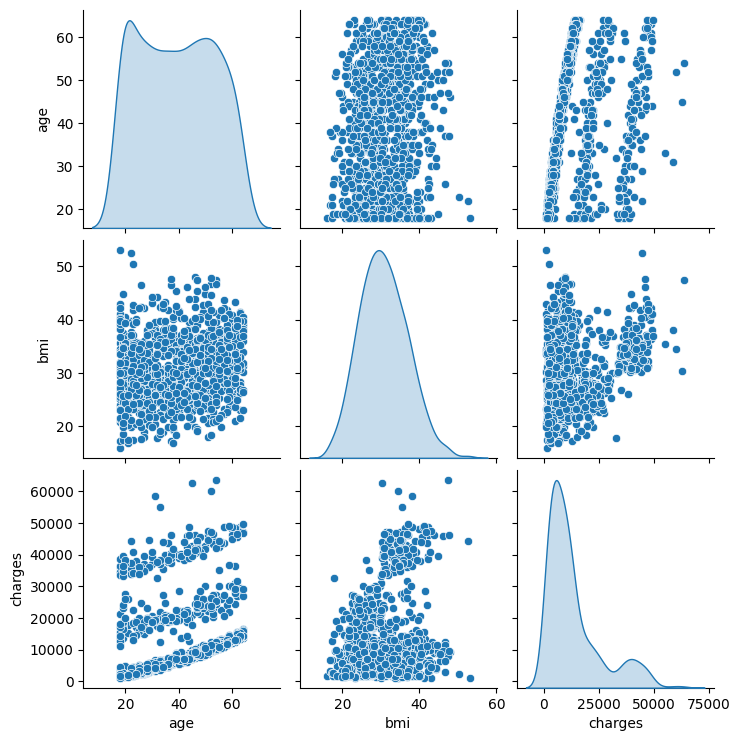

In [42]:
df_num = df_transformed.select('age', 'bmi', 'charges')
sample_df = df_num.sample(fraction=0.75, seed=42)

# Convert to Pandas DataFrame
pandas_df = sample_df.toPandas()

# Create pairplot
sns.pairplot(pandas_df, diag_kind='kde')
plt.show()

The pairplot reveals that there is a linear relationship between age, bmi with charges.

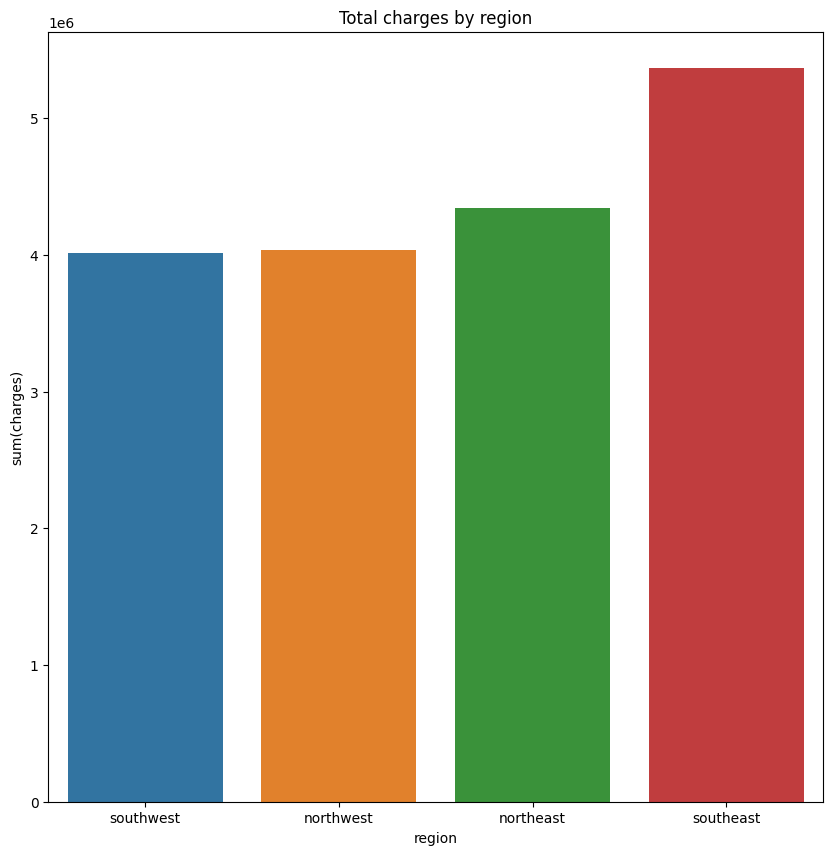

In [43]:
charges = df_transformed.groupBy('region').agg({'charges': 'sum'}).sort('sum(charges)').toPandas()

plt.figure(figsize=(10,10))
ax = sns.barplot(x = 'region', y = 'sum(charges)', data = charges)
ax.set_title('Total charges by region')
plt.show()

Train/Test split
1. Split data into two part : a training set and a testing set
2. Train the model(s) on training set
3. Test the Model(s) on Testing set

1. Linear Regression

In [44]:
from pyspark.ml.regression import LinearRegression
train_data, test_data = df_finalize.randomSplit([0.75, 0.25], seed=42)

# Train the linear regression model
lin_reg_model = LinearRegression(featuresCol='features', labelCol='charges')
lin_reg_model = lin_reg_model.fit(train_data)

# Print the intercept and coefficients
print('Intercept:', lin_reg_model.intercept)
print('Coefficients:', lin_reg_model.coefficients)

Intercept: -13199.890603087702
Coefficients: [252.44477623771516,81.31830721221924,346.9473815530685,544.8616941675992,24057.677298172508,273.209133641106]


In [45]:
from pyspark.ml.evaluation import RegressionEvaluator
train_predictions = lin_reg_model.transform(train_data)
test_predictions = lin_reg_model.transform(test_data)

# Evaluate the model performance using different metrics
evaluator = RegressionEvaluator(labelCol='charges', predictionCol='prediction', metricName='mse')
train_mse = evaluator.evaluate(train_predictions)
test_mse = evaluator.evaluate(test_predictions)
print('MSE train data: {:.3}, \nMSE test data: {:.3}\n'.format(train_mse, test_mse))

evaluator = RegressionEvaluator(labelCol='charges', predictionCol='prediction', metricName='rmse')
train_rmse = evaluator.evaluate(train_predictions)
test_rmse = evaluator.evaluate(test_predictions)
print('RMSE train data: {:.3}, \nRMSE test data: {:.3}\n'.format(train_rmse, test_rmse))

evaluator = RegressionEvaluator(labelCol='charges', predictionCol='prediction', metricName='r2')
train_r2 = evaluator.evaluate(train_predictions)
test_r2 = evaluator.evaluate(test_predictions)
print('R2 train data: {:.3}, \nR2 test data: {:.3}\n'.format(train_r2, test_r2))

# Model Score
lr_test_score = lin_reg_model.evaluate(test_data).r2 * 100
print('Model Score:', lr_test_score)

MSE train data: 3.6e+07, 
MSE test data: 3.89e+07

RMSE train data: 6e+03, 
RMSE test data: 6.24e+03

R2 train data: 0.758, 
R2 test data: 0.721

Model Score: 72.13390159800421


The Model Accuracy is : 72.1%

2. Random Forest Regression

In [46]:
from pyspark.ml.regression import RandomForestRegressor

# Create a RandomForestRegressor model
rfr = RandomForestRegressor(featuresCol='features', labelCol='charges',numTrees=100, seed=0)

# Fit the model to the training data
rfr_model = rfr.fit(train_data)

# Make predictions on the training and test data
train_preds = rfr_model.transform(train_data)
test_preds = rfr_model.transform(test_data)

# Create an evaluator object for the regression metrics
evaluator = RegressionEvaluator(predictionCol='prediction', labelCol='charges')

# Compute the mean squared error on the training and test data
train_mse = evaluator.evaluate(train_preds, {evaluator.metricName: 'mse'})
test_mse = evaluator.evaluate(test_preds, {evaluator.metricName: 'mse'})
print(f"Mean Squared Error on training data: {train_mse:.3f}")
print(f"Mean Squared Error on test data: {test_mse:.3f}")

# Compute the root mean squared error on the training and test data
train_rmse = evaluator.evaluate(train_preds, {evaluator.metricName: 'rmse'})
test_rmse = evaluator.evaluate(test_preds, {evaluator.metricName: 'rmse'})
print(f"Root Mean Squared Error on training data: {train_rmse:.3f}")
print(f"Root Mean Squared Error on test data: {test_rmse:.3f}")

# Compute the R-squared on the training and test data
train_r2 = evaluator.evaluate(train_preds, {evaluator.metricName: 'r2'})
test_r2 = evaluator.evaluate(test_preds, {evaluator.metricName: 'r2'})
print(f"R-squared on training data: {train_r2:.3f}")
print(f"R-squared on test data: {test_r2:.3f}\n")

# Model accuracy score
rfr_test_score = test_r2 * 100
print(f"Model Accuracy Score: {rfr_test_score:.3f}")

Mean Squared Error on training data: 21829236.020
Mean Squared Error on test data: 26153081.601
Root Mean Squared Error on training data: 4672.177
Root Mean Squared Error on test data: 5114.008
R-squared on training data: 0.853
R-squared on test data: 0.813

Model Accuracy Score: 81.281


The Model Accuracy is : 81.3%

3. Decision Tree

In [47]:
from pyspark.ml.regression import DecisionTreeRegressor

# Create a DecisionTreeRegressor model
dtr = DecisionTreeRegressor(featuresCol='features', labelCol='charges',maxDepth=5, seed=0)

# Fit the model to the training data
dtr_model = dtr.fit(train_data)

# Make predictions on the training and test data
train_preds = dtr_model.transform(train_data)
test_preds = dtr_model.transform(test_data)

# Create an evaluator object for the regression metrics
evaluator = RegressionEvaluator(predictionCol='prediction', labelCol='charges')

# Compute the mean squared error on the training and test data
train_mse = evaluator.evaluate(train_preds, {evaluator.metricName: 'mse'})
test_mse = evaluator.evaluate(test_preds, {evaluator.metricName: 'mse'})
print(f"Mean Squared Error on training data: {train_mse:.3f}")
print(f"Mean Squared Error on test data: {test_mse:.3f}")

# Compute the root mean squared error on the training and test data
train_rmse = evaluator.evaluate(train_preds, {evaluator.metricName: 'rmse'})
test_rmse = evaluator.evaluate(test_preds, {evaluator.metricName: 'rmse'})
print(f"Root Mean Squared Error on training data: {train_rmse:.3f}")
print(f"Root Mean Squared Error on test data: {test_rmse:.3f}")

# Compute the R-squared on the training and test data
train_r2 = evaluator.evaluate(train_preds, {evaluator.metricName: 'r2'})
test_r2 = evaluator.evaluate(test_preds, {evaluator.metricName: 'r2'})
print(f"R-squared on training data: {train_r2:.3f}")
print(f"R-squared on test data: {test_r2:.3f}")

# Model accuracy score
dtr_accuracy_score = test_r2*100
print(f"Model Accuracy Score: {dtr_accuracy_score:.3f}")


Mean Squared Error on training data: 17512569.598
Mean Squared Error on test data: 22794771.649
Root Mean Squared Error on training data: 4184.802
Root Mean Squared Error on test data: 4774.387
R-squared on training data: 0.882
R-squared on test data: 0.837
Model Accuracy Score: 83.685


The Model Accuracy is : 83.7%

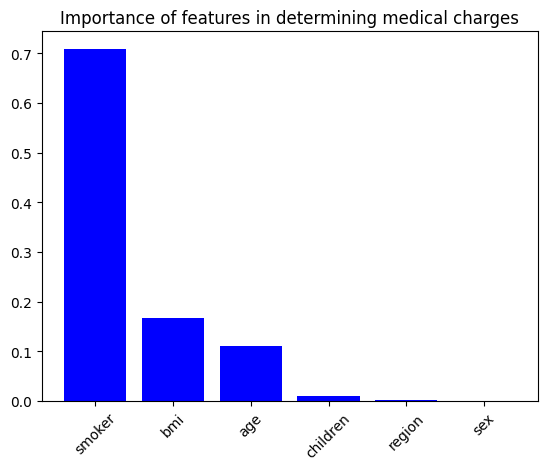

In [48]:
importances = dtr_model.featureImportances.toArray()
variables = ['age', 'sex','bmi', 'children','smoker','region']

# Sort the feature importances in descending order
indices = np.argsort(importances)[::-1]
sorted_variables = [variables[i] for i in indices]

# Plot the feature importances
plt.figure()
plt.title('Importance of features in determining medical charges')
plt.bar(sorted_variables, importances[indices], color='b')
plt.xticks(rotation=45)
plt.show()

Based on the feature importances, we can see that the sex and region independent variables are not very important in determining the medical charges/insurance cost for an individual. Therefore, we can eliminate those variables and generate another model to predict the insurance cost without accounting for those variables. We are only choosing 2 lowest contributing variables to eliminate because it would not be accurate to remove too many potentially unimportant independent variables when generating a model.

4. Polynomial Regression

In [49]:
from pyspark.ml.feature import PolynomialExpansion
from pyspark.ml.linalg import Vectors

features = ['age', 'bmi', 'children', 'smoker_indexed']
target = 'charges'


# Apply PolynomialExpansion transformer
poly_exp = PolynomialExpansion(degree=5, inputCol="features", outputCol="poly_features")
df_new = poly_exp.transform(df_finalize)


In [50]:
from pyspark.ml.feature import PolynomialExpansion
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator


# Split the data into train and test sets
train_data, test_data = df_new.randomSplit([0.75, 0.25], seed=0)

# Define the linear regression model
plr = LinearRegression(featuresCol='poly_features', labelCol=target)

# Train the model on the training data
plr_model = plr.fit(train_data)

# Make predictions on the training and test data
train_preds = plr_model.transform(train_data)
test_preds = plr_model.transform(test_data)

# Evaluate the model using the Root Mean Squared Error (RMSE)
evaluator = RegressionEvaluator(predictionCol='prediction', labelCol=target, metricName='rmse')
train_rmse = evaluator.evaluate(train_preds)
test_rmse = evaluator.evaluate(test_preds)
print(f"Root Mean Squared Error on training data: {train_rmse:.3f}")
print(f"Root Mean Squared Error on test data: {test_rmse:.3f}")

# Evaluate the model using the R-squared score
train_r2 = evaluator.evaluate(train_preds, {evaluator.metricName: 'r2'})
test_r2 = evaluator.evaluate(test_preds, {evaluator.metricName: 'r2'})
print(f"R-squared on training data: {train_r2:.3f}")
print(f"R-squared on test data: {test_r2:.3f}")

# Model accuracy score
plr_accuracy_score = test_r2*100
print(f"Model Accuracy Score: {plr_accuracy_score:.3f}")


Root Mean Squared Error on training data: 4656.350
Root Mean Squared Error on test data: 4540.174
R-squared on training data: 0.856
R-squared on test data: 0.848
Model Accuracy Score: 84.797


The Model Accuracy is : 84.8%

Best Algorithm:
Based on the perfomed machine learning algorithms, it seems that the Polynomial Regression after eliminating two unimportant independent variables produces the most accurate method and will be used to predict the insurance cost for an individual.

1. Polynomial Regression  : 72.1%
2. Random Forest Regressor: 81.3%
3. Decision Tree Regressor: 83.7%
4. Polynomial Regression  : 84.8% 

Predict Charges For New Customer by entering the data:


In [51]:
data = {'age' : 40,
        'sex_indexed' : 1,
        'bmi' : 26.50,
        'children' : 4,
        'smoker_indexed' : 1,
        'region_indexed' : 2}

In [52]:
df = spark.createDataFrame([data])
df.describe

input_cols = ['age', 'sex_indexed', 'bmi', 'children', 'smoker_indexed', 'region_indexed']

# Create the VectorAssembler and transform the DataFrame
assembler = VectorAssembler(inputCols=input_cols, outputCol="features")
df_new_data = assembler.transform(df)


df_new_finalize = df_new_data.select("features")
#df_new_finalize.show()

poly_exp = PolynomialExpansion(degree=5, inputCol="features", outputCol="poly_features")
df_newff = poly_exp.transform(df_new_finalize)

prediction = plr_model.transform(df_newff)

# Extract the predicted charges value
charges = prediction.select("prediction").collect()[0][0]

print("Predicted charges: $%.2f" % charges)

Predicted charges: $31014.59


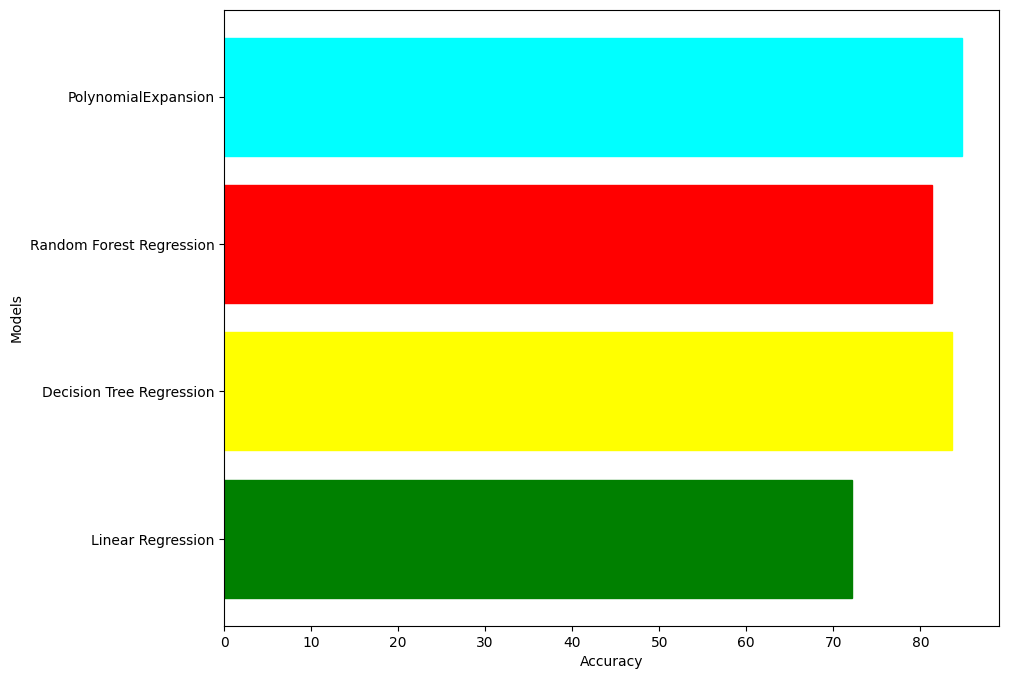

In [53]:
names= ['Linear Regression', 'Decision Tree Regression' ,'Random Forest Regression','PolynomialExpansion']
acc=[lr_test_score,dtr_accuracy_score,rfr_test_score,plr_accuracy_score]
plt.figure(figsize=(10, 8))
graph = plt.barh(names, acc)
plt.xlabel('Accuracy')
plt.ylabel('Models')
graph[0].set_color('green')
graph[1].set_color('yellow')
graph[2].set_color('red')
graph[3].set_color('cyan')